# Głębgokie sieci neuronowe z rozgałęzieniami

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras import datasets, layers, models, callbacks
import matplotlib.pyplot as plt

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
!nvidia-smi

2024-05-12 20:14:16.127835: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 20:14:16.127934: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 20:14:16.248625: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Sun May 12 20:14:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              25W / 250W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  

## Przygotowanie zestawu danych CIFAR10
Przykłady w tym zbiorze mają format 32 na 32 punkty i są kolorowe, a więc posiadają trzy kanały.

In [12]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


### Weryfikacja przykładów

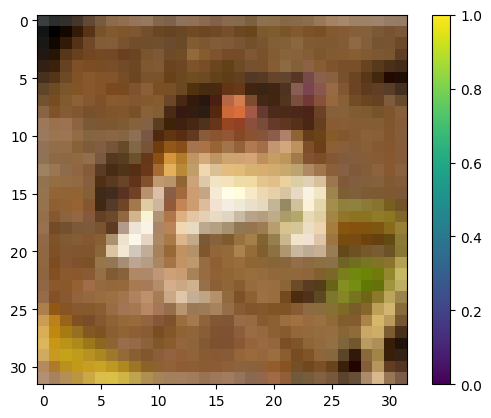

(32, 32, 3)


In [36]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

input_shape = train_images[0].shape
if len(input_shape) < 3:
    input_shape += tuple([1])
print(input_shape)

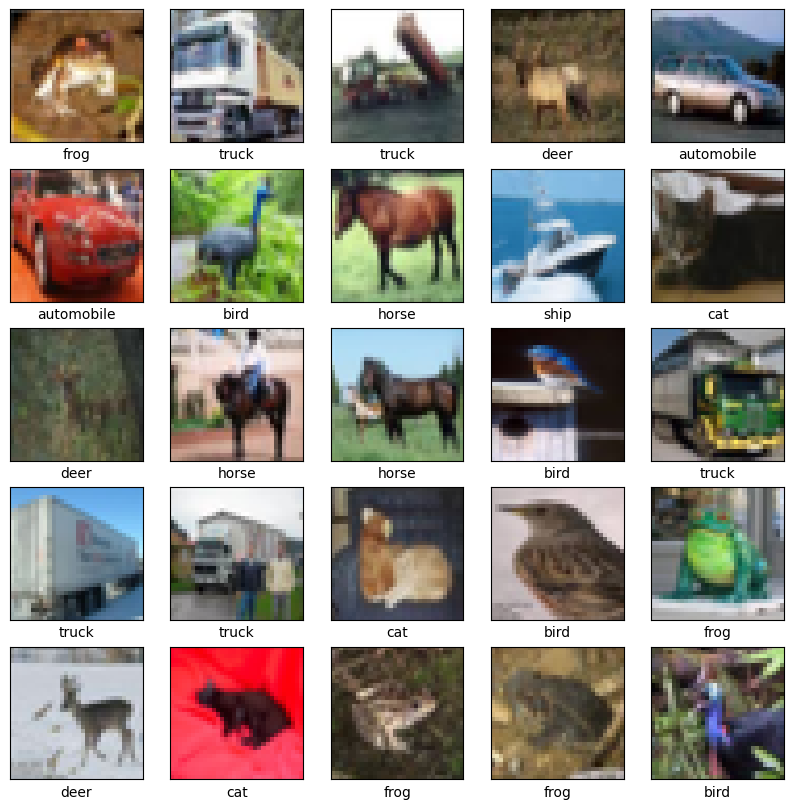

10

In [64]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()
len(class_names)

### Wstępne przetważanie

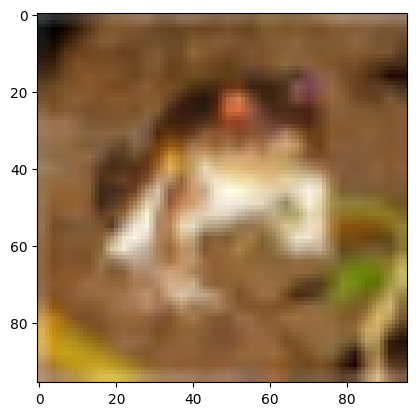

In [59]:
IMG_SIZE = 96
input_resize = layers.Resizing(IMG_SIZE, IMG_SIZE)

plt.imshow(input_resize(train_images[0]))

## Blok zagnieżdżeń

In [56]:
class Inception(tf.keras.Model):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4):
        super().__init__()
        self.b1_1 = layers.Conv2D(c1, 1, activation='relu')
        self.b2_1 = layers.Conv2D(c2[0], 1, activation='relu')
        self.b2_2 = layers.Conv2D(c2[1], 3, padding='same',
                                           activation='relu')
        self.b3_1 = layers.Conv2D(c3[0], 1, activation='relu')
        self.b3_2 = layers.Conv2D(c3[1], 5, padding='same',
                                           activation='relu')
        self.b4_1 = layers.MaxPool2D(3, 1, padding='same')
        self.b4_2 = layers.Conv2D(c4, 1, activation='relu')

    def call(self, x):
        b1 = self.b1_1(x)
        b2 = self.b2_2(self.b2_1(x))
        b3 = self.b3_2(self.b3_1(x))
        b4 = self.b4_2(self.b4_1(x))
        return layers.Concatenate()([b1, b2, b3, b4])

### GoogLeNet

In [66]:
def b1():
    return tf.keras.models.Sequential([
               layers.Conv2D(64, 7, strides=2, padding='same', activation='relu'),
               layers.MaxPool2D(pool_size=3, strides=2, padding='same')
    ])

def b2():
    return tf.keras.Sequential([
            layers.Conv2D(64, 1, activation='relu'),
            layers.Conv2D(192, 3, padding='same', activation='relu'),
            layers.MaxPool2D(pool_size=3, strides=2, padding='same')
    ])
    
def b3():
    return tf.keras.models.Sequential([
            Inception(64, (96, 128), (16, 32), 32),
            Inception(128, (128, 192), (32, 96), 64),
            layers.MaxPool2D(pool_size=3, strides=2, padding='same')
    ])

def b4():
    return tf.keras.Sequential([
        Inception(192, (96, 208), (16, 48), 64),
        Inception(160, (112, 224), (24, 64), 64),
        Inception(128, (128, 256), (24, 64), 64),
        Inception(112, (144, 288), (32, 64), 64),
        Inception(256, (160, 320), (32, 128), 128),
        layers.MaxPool2D(pool_size=3, strides=2, padding='same')
    ])

def b5():
    return tf.keras.Sequential([
        Inception(256, (160, 320), (32, 128), 128),
        Inception(384, (192, 384), (48, 128), 128),
        layers.GlobalAvgPool2D(),
        layers.Flatten()
    ])

def googlenet(classifier_input, num_class):
    return tf.keras.Sequential([
        tf.keras.Input(shape=classifier_input),
        input_resize,
        b1(), b2(), b3(), b4(), b5(),
        layers.Dense(num_class)
    ])


## Blok resztkowy

In [68]:
class Residual(tf.keras.Model):  #@save
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(num_channels, padding='same',
                                            kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(num_channels, kernel_size=3,
                                            padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(num_channels, kernel_size=1,
                                                strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)

### ResNet-18

In [81]:
def resnet_module(num_residuals, num_channels, first_block=False):
    blk = tf.keras.models.Sequential()
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.add(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.add(Residual(num_channels))
    return blk

def resnet(arch, classifier_input, num_classes):
    net = tf.keras.models.Sequential([
        tf.keras.Input(shape=classifier_input),
        input_resize,
        b1()
    ])
    
    for i, b in enumerate(arch):
        net.add(resnet_module(*b, first_block=(i==0)))
        
    net.add(tf.keras.models.Sequential([
        layers.GlobalAvgPool2D(),
        layers.Dense(units=num_classes)]
    ))
    return net

def resnet_18(classifier_input, num_classes):
    return resnet(((2, 64), (2, 128), (2, 256), (2, 512)),
                       classifier_input, num_classes)


### Wybór modelu

In [82]:
model = resnet_18(input_shape, len(class_names))
model.summary()

Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_6 (Resizing)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_99 (Sequential)      │ (None, 24, 24, 64)     │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_101 (Sequential)     │ (None, 24, 24, 64)     │       148,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_102 (Sequential)     │ (None, 12, 12, 128)    │       526,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_103 (Sequential)     │ (None, 6, 6, 256)      │     2,102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_104 (Sequential)     │ (None, 3, 3, 512)      │     8,399,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_105 (Sequential)     │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,192,202 (42.69 MB)

 Trainable params: 11,184,522 (42.67 MB)

 Non-trainable params: 7,680 (30.00 KB)

### Skład i trening modelu
Kluczowym parametrem na tym etapie jest współczynnik uczenia. Zwykle najlepszym wyborem na początek jest wartość rzędu 0.0001 zmniejszana, w miarę jak postępuje uczenie. Moment na zmianę współczynnika rozpoznaje się po zaprzestaniu spadania wartości trafności na zbiorze walidacyjnym. Przy małej liczbie epok, takiej jak zastosowano poniżej, można poszczególne etapy uczenia dostosować ręcznie, natomiast w przypadku wielu epok, rzędu co najmniej kilkudziesięciu, stosuje się rozwiązania zautomatyzowane i wtedy przeważnie stosuje się początkowo większą wartość, rzędu 0.01. Daje to algorytmowi swobodę doboru, choć oznacza to także, że pierwsze kilkanaście epok zostanie zmarnowane wyłącznie na poszukiwanie właściwego współczynnika, bo bardzo rzadko zdarza się, żeby jakakolwiek sieć była się w stanie przy takiej wartości czegoś się nauczyć.

In [50]:
def lr_schedule(epoch):
    if epoch < 3 :
        lr = 0.0001 #5e-4
    elif epoch >= 3 and epoch <5:
        lr = 0.00001 #5e-5
    else:
        lr = 0.000001 #1e-5
    return lr

lr_reducer = callbacks.LearningRateScheduler(lr_schedule)

In [83]:

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels),
                    #callbacks=[lr_reducer],
                    #batch_size=256
                    )

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 67s 30ms/step - accuracy: 0.4202 - loss: 1.5988 - val_accuracy: 0.5089 - val_loss: 1.4532
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.6597 - loss: 0.9632 - val_accuracy: 0.6172 - val_loss: 1.1304
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.7521 - loss: 0.7009 - val_accuracy: 0.6957 - val_loss: 0.9109
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.8267 - loss: 0.4989 - val_accuracy: 0.7302 - val_loss: 0.8040
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.8849 - loss: 0.3282 - val_accuracy: 0.6104 - val_loss: 1.4111
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.9248 - loss: 0.2179 - val_accuracy: 0.6465 - val_loss: 1.2679
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.9517 - loss: 0.1442 - val_accuracy: 0.7215 - val_loss: 1.0353
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.9595 -

### Wyniki

313/313 - 2s - 7ms/step - accuracy: 0.7328 - loss: 1.0849


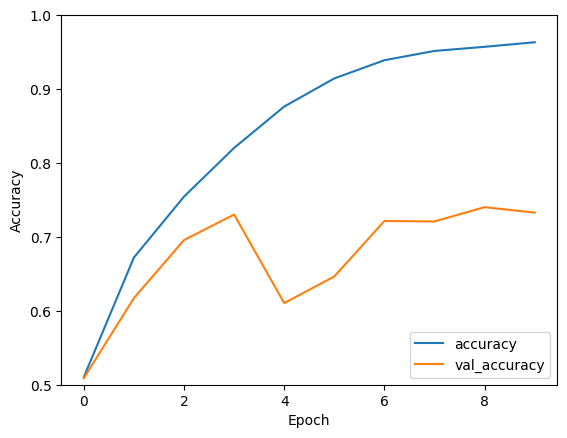

In [84]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [85]:
print(test_acc)

0.7328000068664551


# Zadania
1. Dodaj warstwy normalizacji wsadu. (1 pkt) Przeanalizuj w tym celu sposób wykorzystania tych warstw w sieci AlexNet z poprzedniego ćwiczenia i/lub ResNet z aktualnego oraz poniższy artykuł:
    - [https://proceedings.mlr.press/v37/ioffe15.html](https://proceedings.mlr.press/v37/ioffe15.html)
2. Zmodyfikuj blok `Inception` (szerokość, dobór i kolejność filtrów splotowych). (1 pkt)
    - [https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.html](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.html)
3. Dodaj wygładzanie etykiet (ang. label smoothing), aby poprawić uogólnianie modelu. (1 pkt)
4. Dodaj połączenia resztkowe, analogicznie jak w sieci ResNet. (1 pkt)
    - [https://doi.org/10.1609/aaai.v31i1.11231](https://doi.org/10.1609/aaai.v31i1.11231)
5. Dostosuj wybraną sieć do przyjmowania obrazów w ich oryginalnym rozmiarze, możliwie bez utraty trafności predykcji. (1 pkt) Możesz wzorować się na poniższym artykule:
    - [https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html](https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html)